In [2]:
import numpy as np

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X, y = mnist["data"], mnist["target"]

In [4]:
from sklearn.model_selection import train_test_split

n_test = 10000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n_test, random_state=42)
print(X_train.shape)

(60000, 784)


In [6]:
# Fittons un simple random forest et regardons le temps que cela prend pour entrainer
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Find best params for RandomForest
params_randomForest = [
    {
        "n_estimators": [10, 100, 1000],
        "max_depth" : [10, 100, 1000],
        "max_leaf_nodes": [10 ,100, 1000]
    }
]
randomForest = RandomForestClassifier(n_jobs=-1, n_estimators = 100, max_depth=10)
start = time.time()
randomForest.fit(X_train, y_train)
end = time.time()
print(f"Time taken for fitting: {end - start} ms")
print(f"Score sur le jeu de test: {randomForest.score(X_test, y_test)}")

# randomForest = RandomForestClassifier(n_jobs=-1)
# randomForest_search = GridSearchCV(randomForest, cv=5, param_grid=params_randomForest, refit=True)
# start = time.time()
# randomForest_search.fit(X_train, y_train)
# end = time.time()
# print(f"Best params : {randomForest_search.best_params_}")
# print(f"Best score : {randomForest_search.best_score_}")
# print(f"Time taken for fitting: {end - start} ms")
# print(f"Score sur le jeu de test: {randomForest_search.score(X_test, y_test)}")


Time taken for fitting: 5.245853662490845 ms
Score sur le jeu de test: 0.9431


# Etude de la PCA sur le jeu de données

PCA took 6.6461710929870605 ms

PCA RANDOM
PCA took 5.4541637897491455 ms


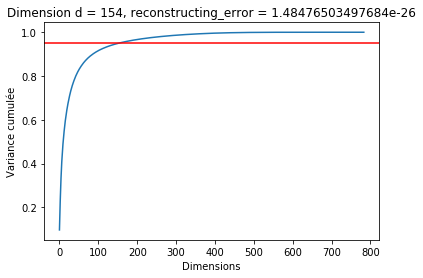

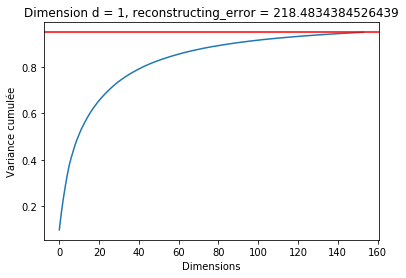

In [8]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def reconstructing_error(X_reduced, X_train, pca):
    X_reconstructed = pca.inverse_transform(X_reduced)
    return mean_squared_error(X_reconstructed, X_train)

def train_PCA(pca, X_train):
    start = time.time()
    pca.fit(X_train)
    end = time.time()
    print(f"PCA took {end - start} ms")
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1

    error = reconstructing_error(pca.transform(X_train), X_train, pca)

    plt.figure()
    plt.xlabel("Dimensions")
    plt.ylabel("Variance cumulée")
    plt.title(f"Dimension d = {d}, reconstructing_error = {error}")
    plt.plot(cumsum)
    plt.axhline(y=0.95, color="r")

pca = PCA()
pca_random = PCA(n_components=154, svd_solver="randomized")
train_PCA(pca, X_train)
print("\nPCA RANDOM")
train_PCA(pca_random, X_train)


In [10]:
# Maintenant, entrainons notre random forest sur le jeu réduit, et observons le temps d'entrainement, ainsi que le score à la fin

X_train_pca = pca_random.transform(X_train)
print(f"Dimensions de la matrice réduite: {X_train_pca.shape}")

rf_pca = RandomForestClassifier(n_jobs=-1, n_estimators = 100, max_depth=10)
start = time.time()
rf_pca.fit(X_train_pca, y_train)
end = time.time()
print(f"Time taken for fitting: {end - start} ms")
print(f"Score sur le jeu de test: {rf_pca.score(pca_random.transform(X_test), y_test)}")

# On observe que le modèle prend plus de temps à entrainer, mais il perd en plus en performance

Dimensions de la matrice réduite: (60000, 154)
Time taken for fitting: 12.607519388198853 ms
Score sur le jeu de test: 0.9151


# t-SNE

Starting training of TSNE
TSNE fitting took 5.213017702102661 ms
TSNE shape after reducing: (1000, 2)


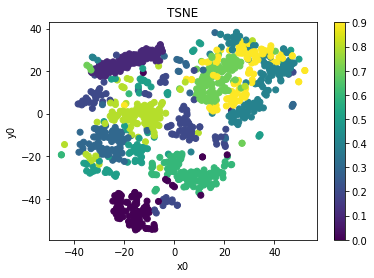

In [15]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS

def train_reducer(model, name, X_train):
    print(f"Starting training of {name}")
    start = time.time()
    X_embedded = model.fit_transform(X_train)
    end = time.time()
    print(f"{name} fitting took {end - start} ms")
    print(f"{name} shape after reducing: {X_embedded.shape}")
    return X_embedded

def visualize_reduction(X_reduced, y, name):
    x0 = X_reduced[:, 0]
    x1 = X_reduced[:, 1]
    y_int = [int(n) for n in y]

    plt.figure()
    plt.xlabel("x0")
    plt.ylabel("y0")
    plt.title(f"{name}")
    plt.scatter(x0, x1, c=np.array(y_int) / 10)
    plt.colorbar()

def train_and_visualize(model, name, X_train, y_train):
    X_reduced = train_reducer(model, name, X_train)
    visualize_reduction(X_reduced, y_train, name)

models_to_train = [
    (TSNE(n_components=2, random_state=42), "TSNE"),
    # (PCA(n_components=2, svd_solver="randomized"), "PCA"),
    # (LocallyLinearEmbedding(n_components=2, n_neighbors=10), "LLE"),
    # (MDS(n_components=2), "MDS")
]

n_samples = 20
for model, name in models_to_train:
    # train_and_visualize(model, name, X_train[:n_samples,], y[:n_samples])
    train_and_visualize(model, name, X_train_pca, y_train)

# Taking too long : 30 min
